# Databazi-treniranje


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 791918971/791918971 [00:45<00:00, 17356890.32it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 8565485.24it/s] 


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet
Training on CIFAR-10 dataset
[1,  2000] loss: 0.011
[1,  4000] loss: 0.011
[1,  6000] loss: 0.011
[1,  8000] loss: 0.011
[1, 10000] loss: 0.011
[1, 12000] loss: 0.011
[2,  2000] loss: 0.011
[2,  4000] loss: 0.011
[2,  6000] loss: 0.011
[2,  8000] loss: 0.011
[2, 10000] loss: 0.011
[2, 12000] loss: 0.011
Finished Training
Training on CIFAR-100 dataset
[1,  2000] loss: 0.016
[1,  4000] loss: 0.016
[1,  6000] loss: 0.016
[1,  8000] loss: 0.016
[1, 10000] loss: 0.016
[1, 12000] loss: 0.016
[2,  2000] loss: 0.016
[2,  4000] loss: 0.016
[2,  6000] loss: 0.015
[2,  8000] loss: 0.016
[2, 10000] loss: 0.016
[2, 12000] loss: 0.016
Finished Training
Training on Oxford-IIIT Pet dataset
Finished Training
Testing on CIFAR-10 dataset


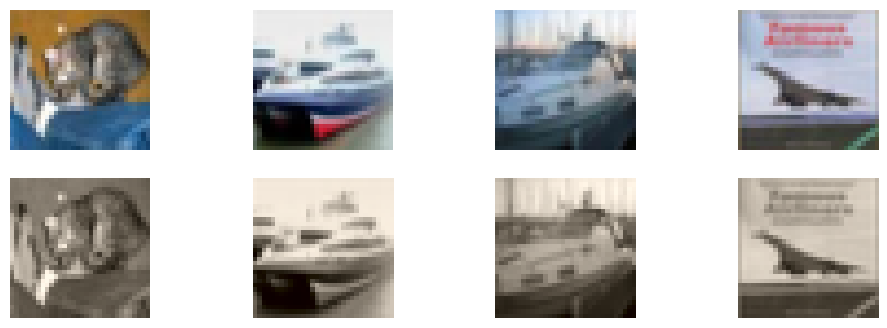

Testing on CIFAR-100 dataset


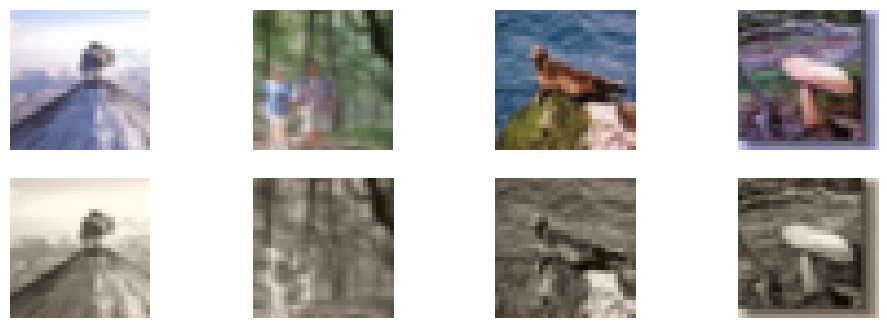

Testing on Oxford-IIIT Pet dataset


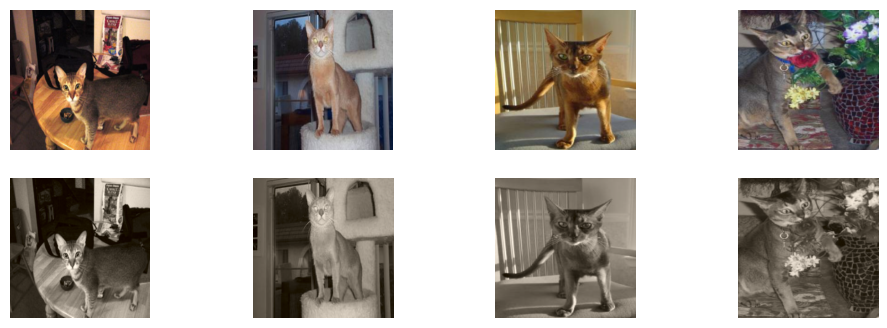

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2lab, lab2rgb
from torchvision import models, datasets

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 4

# Define transformations
transform = transforms.Compose([transforms.ToTensor()])

# CIFAR-10 Dataset
cifar10_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

cifar10_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=batch_size, shuffle=False, num_workers=2)

# CIFAR-100 Dataset
cifar100_trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
cifar100_trainloader = torch.utils.data.DataLoader(cifar100_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

cifar100_testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
cifar100_testloader = torch.utils.data.DataLoader(cifar100_testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Oxford-IIIT Pet Dataset (higher resolution)
pet_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

pet_trainset = datasets.OxfordIIITPet(root='./data', split='trainval', download=True, transform=pet_transform)
pet_trainloader = torch.utils.data.DataLoader(pet_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

pet_testset = datasets.OxfordIIITPet(root='./data', split='test', download=True, transform=pet_transform)
pet_testloader = torch.utils.data.DataLoader(pet_testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Functions to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Preprocessing function
def preprocess_images(images):
    images = images.cpu().numpy()  # Move tensor to CPU and then convert to NumPy array
    lab_images = rgb2lab(images.transpose((0, 2, 3, 1)))
    l = lab_images[:, :, :, 0] / 100.0
    ab = lab_images[:, :, :, 1:] / 128.0
    l = torch.from_numpy(l).float().unsqueeze(1)
    ab = torch.from_numpy(ab).float().permute(0, 3, 1, 2)
    l = l.repeat(1, 3, 1, 1)  # Duplicate the grayscale channel to create 3-channel input
    return l, ab

# Define the Colorization Network
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        vgg = models.vgg16(pretrained=True)
        self.features = nn.Sequential(*list(vgg.features.children())[:-1])
        self.conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(32, 2, kernel_size=3, padding=1)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    def forward(self, x):
        x = self.features(x)
        x = F.relu(self.conv1(x))
        x = self.upsample(x)
        x = F.relu(self.conv2(x))
        x = self.upsample(x)
        x = F.relu(self.conv3(x))
        x = self.upsample(x)
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        x = self.upsample(x)
        return x

net = ColorizationNet().to(device)

# Define Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Training function
def train_model(trainloader, epochs=2):
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, _ = data
            inputs = inputs.to(device)
            l, ab = preprocess_images(inputs)
            l, ab = l.to(device), ab.to(device)
            optimizer.zero_grad()
            outputs = net(l)
            loss = criterion(outputs, ab)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
    print('Finished Training')

# Train the network on CIFAR-10, CIFAR-100, and Oxford-IIIT Pet datasets
print("Training on CIFAR-10 dataset")
train_model(cifar10_trainloader)

print("Training on CIFAR-100 dataset")
train_model(cifar100_trainloader)

print("Training on Oxford-IIIT Pet dataset")
train_model(pet_trainloader)

# Function to colorize images
def colorize_image(model, img):
    model.eval()
    img = img.to(device)
    l, _ = preprocess_images(img.unsqueeze(0))
    l = l.to(device)
    with torch.no_grad():
        ab = model(l)
    ab = ab * 128.0
    lab_img = torch.cat((l[0][:1] * 100.0, ab[0]), 0).cpu().numpy().transpose((1, 2, 0))
    colorized_img = lab2rgb(lab_img)
    return colorized_img

# Test the network on the test data
def test_model(testloader):
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    colorized_imgs = [colorize_image(net, img) for img in images]

    # Plot the original and colorized images
    fig, axes = plt.subplots(2, batch_size, figsize=(12, 4))
    for i in range(batch_size):
        axes[0, i].imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
        axes[0, i].axis('off')
        axes[1, i].imshow(colorized_imgs[i])
        axes[1, i].axis('off')
    plt.show()

print("Testing on CIFAR-10 dataset")
test_model(cifar10_testloader)

print("Testing on CIFAR-100 dataset")
test_model(cifar100_testloader)

print("Testing on Oxford-IIIT Pet dataset")
test_model(pet_testloader)


UNetGenerator(
  (down1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (down5): Sequential(
    (0): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0

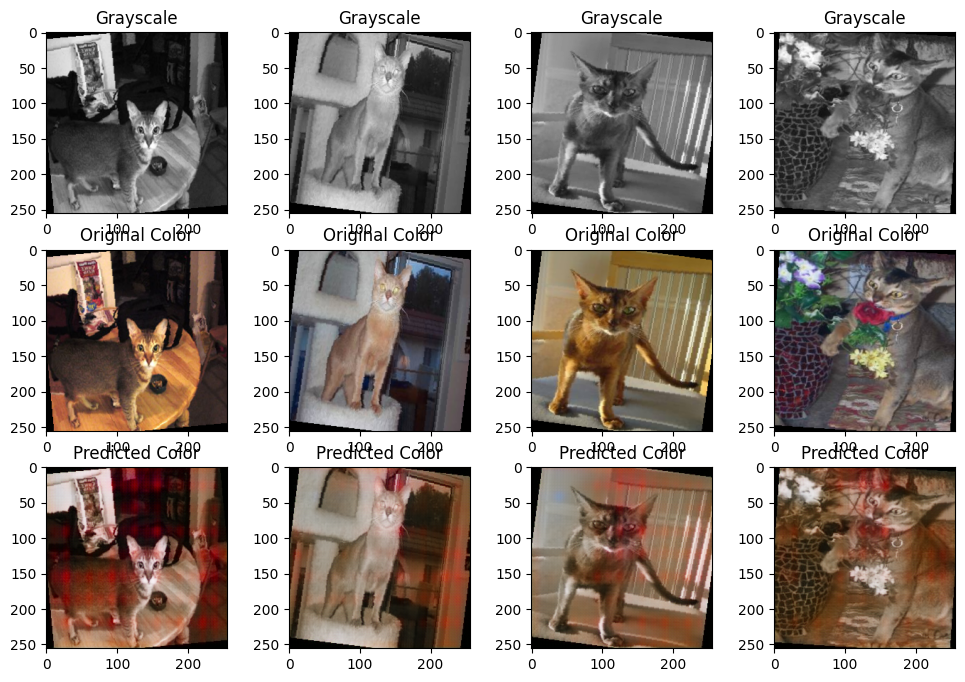

In [ ]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import OxfordIIITPet

class UNetGenerator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetGenerator, self).__init__()

        def down_block(in_channels, out_channels, normalize=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2))
            return nn.Sequential(*layers)

        def up_block(in_channels, out_channels, dropout=0.0):
            layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                      nn.BatchNorm2d(out_channels),
                      nn.ReLU(inplace=True)]
            if dropout:
                layers.append(nn.Dropout(dropout))
            return nn.Sequential(*layers)

        self.down1 = down_block(in_channels, 64, normalize=False)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512)
        self.down5 = down_block(512, 512)
        self.down6 = down_block(512, 512)
        self.down7 = down_block(512, 512)
        self.down8 = down_block(512, 512, normalize=False)

        self.up1 = up_block(512, 512, dropout=0.5)
        self.up2 = up_block(1024, 512, dropout=0.5)
        self.up3 = up_block(1024, 512, dropout=0.5)
        self.up4 = up_block(1024, 512)
        self.up5 = up_block(1024, 256)
        self.up6 = up_block(512, 128)
        self.up7 = up_block(256, 64)
        self.up8 = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        u8 = self.up8(torch.cat([u7, d1], 1))

        return u8

# Test generator architecture
netG = UNetGenerator(1, 3).to(device)
print(netG)
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()

        def discriminator_block(in_channels, out_channels, stride, normalize=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        self.model = nn.Sequential(
            discriminator_block(in_channels, 64, stride=2, normalize=False),
            discriminator_block(64, 128, stride=2),
            discriminator_block(128, 256, stride=2),
            discriminator_block(256, 512, stride=1),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

# Test discriminator architecture
netD = Discriminator(4).to(device)
print(netD)
class GrayscaleColorDataset(torch.utils.data.Dataset):
    def __init__(self, root, split='trainval', transform=None):
        self.dataset = OxfordIIITPet(root=root, split=split, download=True, target_types='category')
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        if self.transform:
            img = self.transform(img)
        gray_img = transforms.Grayscale()(img)
        return gray_img, img

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

trainset = GrayscaleColorDataset(root='./data', split='trainval', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

testset = GrayscaleColorDataset(root='./data', split='test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
# Initialize generator and discriminator
netG = UNetGenerator(1, 3).to(device)
netD = Discriminator(4).to(device)

# Loss functions
criterion_GAN = nn.MSELoss()
criterion_pixelwise = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
for epoch in range(10):
    for i, data in enumerate(trainloader):
        gray_images, color_images = data
        gray_images, color_images = gray_images.to(device), color_images.to(device)

        # Adversarial ground truths
        valid = torch.ones((gray_images.size(0), 1, 30, 30), requires_grad=False).to(device)
        fake = torch.zeros((gray_images.size(0), 1, 30, 30), requires_grad=False).to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Real images
        pred_real = netD(gray_images, color_images)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake images
        fake_images = netG(gray_images)
        pred_fake = netD(gray_images, fake_images.detach())
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # GAN loss
        pred_fake = netD(gray_images, fake_images)
        loss_GAN = criterion_GAN(pred_fake, valid)

        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(fake_images, color_images)

        # Total loss
        loss_G = loss_GAN + 100 * loss_pixel
        loss_G.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{10}] [Batch {i}/{len(trainloader)}] [D loss: {loss_D.item():.4f}] [G loss: {loss_G.item():.4f}]")

print('Finished Training')
# Test the network on the test data
dataiter = iter(testloader)
gray_images, color_images = next(dataiter)

# Print original and colorized images
def show_images(gray, color, predicted):
    fig, axs = plt.subplots(3, 4, figsize=(12, 8))
    for i in range(4):
        axs[0, i].imshow(gray[i].cpu().squeeze(), cmap='gray')
        axs[0, i].set_title('Grayscale')
        axs[1, i].imshow(color[i].cpu().permute(1, 2, 0))
        axs[1, i].set_title('Original Color')
        axs[2, i].imshow(predicted[i].cpu().permute(1, 2, 0))
        axs[2, i].set_title('Predicted Color')
    plt.show()

gray_images, color_images = gray_images.to(device), color_images.to(device)
netG.eval()
with torch.no_grad():
    predicted_images = netG(gray_images)
show_images(gray_images, color_images, predicted_images)


100%|██████████| 791918971/791918971 [00:30<00:00, 25970312.57it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 10777432.17it/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also u

[Epoch 0/10] [Batch 0/460] [D loss: 0.7246] [G loss: 69.5183]
[Epoch 0/10] [Batch 100/460] [D loss: 0.0147] [G loss: 8.9104]
[Epoch 0/10] [Batch 200/460] [D loss: 0.0197] [G loss: 6.7601]
[Epoch 0/10] [Batch 300/460] [D loss: 0.2381] [G loss: 5.3870]
[Epoch 0/10] [Batch 400/460] [D loss: 0.0526] [G loss: 6.2972]
[Epoch 1/10] [Batch 0/460] [D loss: 0.1491] [G loss: 5.3530]
[Epoch 1/10] [Batch 100/460] [D loss: 0.0632] [G loss: 6.6139]
[Epoch 1/10] [Batch 200/460] [D loss: 0.0516] [G loss: 7.1668]
[Epoch 1/10] [Batch 300/460] [D loss: 0.0512] [G loss: 7.2765]
[Epoch 1/10] [Batch 400/460] [D loss: 0.0513] [G loss: 7.0673]
[Epoch 2/10] [Batch 0/460] [D loss: 0.0430] [G loss: 7.4419]
[Epoch 2/10] [Batch 100/460] [D loss: 0.3301] [G loss: 6.3913]
[Epoch 2/10] [Batch 200/460] [D loss: 0.1246] [G loss: 6.5356]
[Epoch 2/10] [Batch 300/460] [D loss: 0.0724] [G loss: 7.1563]
[Epoch 2/10] [Batch 400/460] [D loss: 0.1740] [G loss: 6.6018]
[Epoch 3/10] [Batch 0/460] [D loss: 0.5871] [G loss: 5.1520]

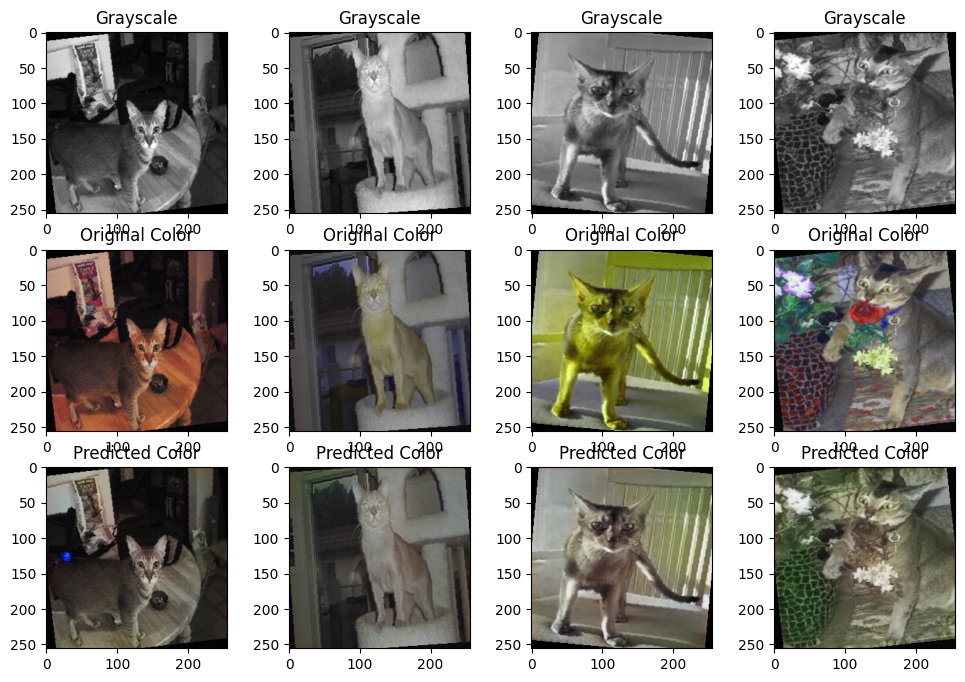

In [ ]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import OxfordIIITPet
from torchvision.models import vgg19

class UNetGenerator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetGenerator, self).__init__()

        def down_block(in_channels, out_channels, normalize=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        def up_block(in_channels, out_channels, dropout=0.0):
            layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                      nn.BatchNorm2d(out_channels),
                      nn.ReLU(inplace=True)]
            if dropout:
                layers.append(nn.Dropout(dropout))
            return nn.Sequential(*layers)

        self.down1 = down_block(in_channels, 64, normalize=False)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512)
        self.down5 = down_block(512, 512)
        self.down6 = down_block(512, 512)
        self.down7 = down_block(512, 512)
        self.down8 = down_block(512, 512, normalize=False)

        self.up1 = up_block(512, 512, dropout=0.5)
        self.up2 = up_block(1024, 512, dropout=0.5)
        self.up3 = up_block(1024, 512, dropout=0.5)
        self.up4 = up_block(1024, 512)
        self.up5 = up_block(1024, 256)
        self.up6 = up_block(512, 128)
        self.up7 = up_block(256, 64)
        self.up8 = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        u8 = self.up8(torch.cat([u7, d1], 1))

        return u8

class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()

        def discriminator_block(in_channels, out_channels, stride, normalize=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        self.model = nn.Sequential(
            discriminator_block(in_channels, 64, stride=2, normalize=False),
            discriminator_block(64, 128, stride=2),
            discriminator_block(128, 256, stride=2),
            discriminator_block(256, 512, stride=1),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

class GrayscaleColorDataset(torch.utils.data.Dataset):
    def __init__(self, root, split='trainval', transform=None):
        self.dataset = OxfordIIITPet(root=root, split=split, download=True, target_types='category')
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        if self.transform:
            img = self.transform(img)
        gray_img = transforms.Grayscale()(img)
        return gray_img, img

# Additional augmentations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

trainset = GrayscaleColorDataset(root='./data', split='trainval', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True, num_workers=4)

testset = GrayscaleColorDataset(root='./data', split='test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize generator and discriminator
netG = UNetGenerator(1, 3).to(device)
netD = Discriminator(4).to(device)

# Loss functions
criterion_GAN = nn.MSELoss()
criterion_pixelwise = nn.L1Loss()

# Perceptual loss using VGG19
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        self.vgg = vgg19(pretrained=True).features[:12].eval()
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.criterion = nn.L1Loss()

    def forward(self, x, y):
        x_vgg = self.vgg(x)
        y_vgg = self.vgg(y)
        return self.criterion(x_vgg, y_vgg)

criterion_perceptual = PerceptualLoss().to(device)

# Optimizers
optimizer_G = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for i, data in enumerate(trainloader):
        gray_images, color_images = data
        gray_images, color_images = gray_images.to(device), color_images.to(device)

        # Adversarial ground truths
        valid = torch.ones((gray_images.size(0), 1, 30, 30), requires_grad=False).to(device)
        fake = torch.zeros((gray_images.size(0), 1, 30, 30), requires_grad=False).to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Real images
        pred_real = netD(gray_images, color_images)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake images
        fake_images = netG(gray_images)
        pred_fake = netD(gray_images, fake_images.detach())
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # GAN loss
        pred_fake = netD(gray_images, fake_images)
        loss_GAN = criterion_GAN(pred_fake, valid)

        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(fake_images, color_images)

        # Perceptual loss
        loss_perceptual = criterion_perceptual(fake_images, color_images)

        # Total loss
        loss_G = loss_GAN + 100 * loss_pixel + 0.1 * loss_perceptual
        loss_G.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(trainloader)}] [D loss: {loss_D.item():.4f}] [G loss: {loss_G.item():.4f}]")

print('Finished Training')
# Test the network on the test data
dataiter = iter(testloader)
gray_images, color_images = next(dataiter)

# Print original and colorized images
def show_images(gray, color, predicted):
    fig, axs = plt.subplots(3, 4, figsize=(12, 8))
    for i in range(4):
        axs[0, i].imshow(gray[i].cpu().squeeze(), cmap='gray')
        axs[0, i].set_title('Grayscale')
        axs[1, i].imshow(color[i].cpu().permute(1, 2, 0))
        axs[1, i].set_title('Original Color')
        axs[2, i].imshow(predicted[i].cpu().permute(1, 2, 0))
        axs[2, i].set_title('Predicted Color')
    plt.show()

gray_images, color_images = gray_images.to(device), color_images.to(device)
netG.eval()
with torch.no_grad():
    predicted_images = netG(gray_images)
show_images(gray_images, color_images, predicted_images)
